In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
#Initializing spotipy
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="97a410ffe0074311bf2ae56568f5be80",
                                                           client_secret="eb9a8cf6157b467380cb09f34c665949"))


In [3]:
#the playlists

#metal & rock playlist
metal_playlist = "7dUHWQzNHsfzQNuPkg0scx"
#classical playlist
classical_playlist = "37i9dQZF1DWWEJlAGA9gs0"
#pop playlist
pop_playlist = "6mtYuOxzl58vSGnEDtZ9uB"


In [4]:
#code to pass the 100 limit for the tracks got from the api

def get_all_tracks(playlist):
    results = sp.user_playlist_tracks("spotify", playlist)
    tracks = results['items'] # to pass in

    for oset in range(100,results['total'],100):
        results = sp.user_playlist_tracks("spotify", playlist, offset=oset)
        tracks += results['items']
    
    return tracks


all_tracks_metal = get_all_tracks(metal_playlist)
all_tracks_classical = get_all_tracks(classical_playlist)
all_tracks_pop = get_all_tracks(pop_playlist)

In [5]:
# Getting all the artists

def get_artists_from_playlist(playlist_id, tracks):
    
    tracks_from_playlist = tracks
    
    artists = []
    
    for track in tracks_from_playlist:
        artist_info = track['track']['artists'][0]
        artists.append(artist_info['name'])
    
    return artists

all_artist_metal = get_artists_from_playlist(metal_playlist,all_tracks_metal)
all_artist_classical = get_artists_from_playlist(classical_playlist,all_tracks_classical)
all_artist_pop = get_artists_from_playlist(pop_playlist,all_tracks_pop)

In [6]:
#get song names & track ids

def get_song_names(tracks):
    song_actual_names = [track['track']['name'] for track in tracks]
    track_ids = [track['track']['id'] for track in tracks]
    
    return song_actual_names,track_ids

song_names_metal,id_track_metal = get_song_names(all_tracks_metal)
song_names_classical,id_track_classical = get_song_names(all_tracks_classical)
song_names_pop,id_track_pop = get_song_names(all_tracks_pop)

In [7]:
#get all genres and popularity

def get_pop_and_genre(tracks):
    
    genre = []
    popularity = []
    
    for elem in tracks:
        artist01 = sp.artist(elem['track']["album"]["artists"][0]["external_urls"]["spotify"])
        genre.append(artist01["genres"][0] if artist01["genres"] else "genreless")
        popularity.append(artist01["popularity"])
        
        
    return genre,popularity

genre_metal,popularity_metal = get_pop_and_genre(all_tracks_metal)
genre_classical,popularity_classical = get_pop_and_genre(all_tracks_classical)
genre_pop,popularity_pop = get_pop_and_genre(all_tracks_pop)

In [8]:
#gathering main features and turning them into a dataframe

def main_features_to_df(track_ids):
    the_list = []
    for i in track_ids:
        the_list.append(sp.audio_features(i))
    #looping inside the nested list to be able to convert into a df    
    converted = [i for elem in the_list for i in elem]    
    df = pd.json_normalize(converted)
    
    return df
        
df_metal = main_features_to_df(id_track_metal)
df_classical = main_features_to_df(id_track_classical)
df_pop = main_features_to_df(id_track_pop)

In [9]:
# adding previous single gathered features to the current df

def add_features_to_df(song_actual_names,artist_list,genre,popularity,features_df):
    df_song_name = pd.DataFrame(song_actual_names, columns = ["song_name"])
    df_artists = pd.DataFrame(artist_list,columns = ["artists"])
    df_genre = pd.DataFrame(genre,columns = ["genre"])
    df_popularity = pd.DataFrame(popularity,columns = ["popularity"])
    
    final_boss_df = pd.concat([features_df, df_song_name,df_artists,df_genre,df_popularity], axis=1)
    
    return final_boss_df

final_df_metal = add_features_to_df(song_names_metal,all_artist_metal,genre_metal,popularity_metal,df_metal)
final_df_classical = add_features_to_df(song_names_classical,all_artist_classical,genre_classical,popularity_classical,df_classical)
final_df_pop = add_features_to_df(song_names_pop,all_artist_pop,genre_pop,popularity_pop,df_pop)

Treating the dataframe:

In [36]:
scaler = StandardScaler()

def scaling_df(current_df):
    df_to_scale = current_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    #scaler = StandardScaler()
    scaled_df02 = scaler.fit_transform(df_to_scale)
    scaled_df01 = pd.DataFrame(scaled_df02)
    
    #adding the non numerical wanted columns to the main scaled df                         
    scaled_df = scaled_df01.copy()
    scaled_df.columns = df_to_scale.columns
    scaled_df["song_name"] = current_df["song_name"]
    scaled_df["artists"] = current_df["artists"]
    scaled_df["genre"] = current_df["genre"]
    scaled_df
                             
    return scaled_df01,scaled_df

df_to_scale_metal,scaled_df_metal = scaling_df(final_df_metal)
df_to_scale_classical,scaled_df_classical = scaling_df(final_df_classical)
df_to_scale_pop,scaled_df_pop = scaling_df(final_df_pop)

In [37]:
scaled_df_metal

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,song_name,artists,genre
0,-1.602274,-0.332506,0.182485,0.292946,-1.225509,-0.450431,1.852176,1.415348,0.073077,-1.050764,-0.999128,-1.603424,The Dawning Of Orphiucus,Astra,genreless
1,0.207887,-2.050889,-0.978466,-3.154764,0.815987,-0.314904,2.286469,1.344892,-0.665325,0.165361,-1.070146,1.314565,Planet Caravan,Black Sabbath,album rock
2,-0.760649,-1.371740,-1.558941,-1.475254,0.815987,-0.095481,-0.570435,-1.088078,-0.252884,-1.046436,-0.587749,1.360882,The End,The Doors,acid rock
3,0.909241,-0.127394,1.633672,-1.539039,-1.225509,-0.392348,0.879226,-0.722711,0.352473,1.082863,-0.563641,1.360882,Riders on the Storm - New Stereo Mix,The Doors,acid rock
4,-1.067909,-0.774636,0.472722,-0.196244,-1.225509,-0.505287,1.330352,0.930288,-0.405886,-1.254605,0.507958,1.638786,Shine On You Crazy Diamond - Parts 1 - 7;Edit;...,Pink Floyd,album rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,0.067617,0.889050,1.633672,-0.052664,-1.225509,0.265923,-0.502430,-1.091249,-0.432495,1.537287,1.047843,0.805075,Don't You Feel Small,The Moody Blues,album rock
664,-0.159489,0.250924,-1.268703,0.724449,-1.225509,-0.385894,-0.012925,-1.087997,-0.518975,-0.124605,0.634747,0.944027,Iron Sky,Paolo Nutini,british soul
665,0.060937,-0.788311,0.182485,0.217216,-1.225509,-0.540782,1.714145,-1.089793,-0.106534,0.083132,-1.110738,1.221930,I Put A Spell On You,Nina Simone,indie r&b
666,1.517082,-1.326160,1.053197,-1.659748,0.815987,0.675728,0.576231,0.098369,-0.844271,1.684434,1.157806,1.221930,Baltimore,Nina Simone,indie r&b


In [38]:
#merging the different genres dataframes

scaled_complete_frames = [scaled_df_metal,scaled_df_classical,scaled_df_pop]
the_big_boi_frame = pd.concat(scaled_complete_frames)
the_big_boi_frame

#merging all the scaled numericals
scaled_numerical_frames = [df_to_scale_metal,df_to_scale_classical,df_to_scale_pop]
numericals_big_boi_frame = pd.concat(scaled_numerical_frames)

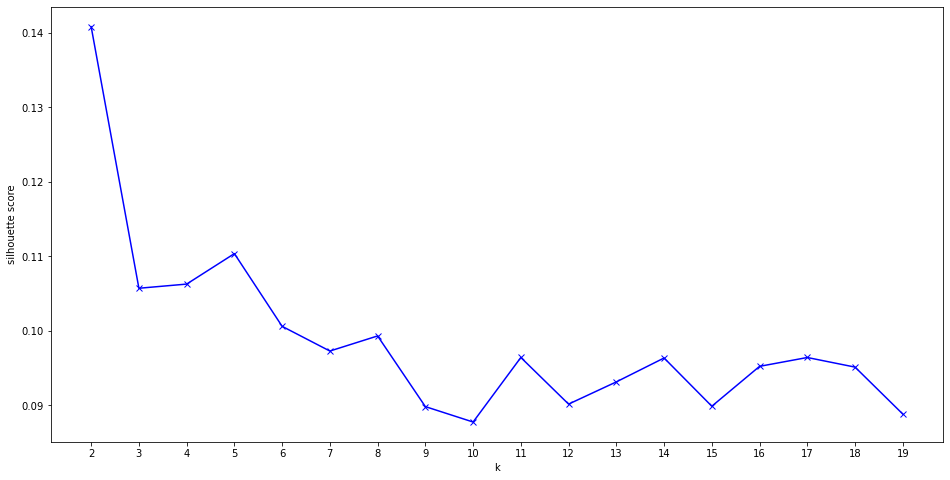

In [39]:
#applying silhouette to see how many clusters is a good number to apply

K = range(2, 20)

silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numericals_big_boi_frame)
    silhouette.append(silhouette_score(numericals_big_boi_frame, kmeans.predict(numericals_big_boi_frame)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

In [40]:
#applying the clustering

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(numericals_big_boi_frame)

KMeans(n_clusters=7, random_state=42)

In [41]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(numericals_big_boi_frame)
clusters

array([4, 5, 5, ..., 3, 0, 0])

In [42]:
#assigning the clusters to the main final df
the_big_boi_frame["clusters"] = clusters

In [43]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    221
1    232
2     25
3    231
4    159
5    231
6     95
dtype: int64

In [44]:
the_big_boi_frame.groupby(['clusters','genre'], as_index=False).count().sort_values(['clusters', 'key'], ascending=[True, False])[['genre', 'clusters', 'key']].reset_index(drop=True).groupby(["clusters"]).head(3)

,genre,clusters,key
0,dance pop,0,30
1,alternative metal,0,24
2,genreless,0,14
84,dance pop,1,30
85,album rock,1,22
86,alternative metal,1,16
178,genreless,2,7
179,alternative metal,2,3
180,alternative rock,2,2
193,dance pop,3,46


In [52]:
the_big_boi_frame = the_big_boi_frame.reset_index(drop=True)

In [53]:
#getting song and recomending song kinda here
def recomend_song():
    song_name = input("Choose a song: ")
    results = sp.search(q=f'track:{song_name}', limit=1)
    track_id = results['tracks']['items'][0]['id'] if results['tracks']['items'] else None
    while not track_id:
        return recomend_song()
    # get song features with the obtained id
    audio_features = sp.audio_features(track_id)
    #get song popularity and genre
    song_pop_genre = sp.artist(results['tracks']["items"][0]["album"]["artists"][0]["external_urls"]["spotify"])
    the_genre = song_pop_genre["genres"][0] if song_pop_genre["genres"] else "generless"
    the_pop = song_pop_genre["popularity"]
    #create the df
    df_uni_song = pd.DataFrame(audio_features)
    df_uni_song["popularity"] = the_pop
    #merge the datas
    new_features = df_uni_song[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    df_uni_song["genre"] = the_genre
    #scale features
    #scaler = StandardScaler()
    scaled_x = scaler.transform(new_features)
    
    # predict cluster
    cluster = kmeans.predict(scaled_x)
    # filter dataset to predicted cluster
    filtered_df = the_big_boi_frame[the_big_boi_frame['clusters'] == cluster[0]][new_features.columns]
    # get closest song from filtered dataset
    closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)
    # return it in a readable way
    print('\n [RECOMMENDED SONG]')
    return ' - '.join([the_big_boi_frame.loc[closest]['song_name'].values[0], the_big_boi_frame.loc[closest]['artists'].values[0]])

In [68]:
recomend_song()

Choose a song: Vicarious

 [RECOMMENDED SONG]


'Hypnosis - Domadora'